In [1]:
import sys
sys.path.append('..')

In [54]:
from pathlib import Path
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myutils.matplotlib import matplotlib_seaborn_style, matplotlib_latex

from src.missing_values import impute_average

matplotlib_seaborn_style()
# matplotlib_latex()

In [3]:
figures_dir = Path('../data/report_figures')
figures_dir.mkdir(exist_ok=True)

In [28]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'])

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [30]:
# all_dates = np.arange(data['date'].min(), data['date'].max() + timedelta(days=1), timedelta(days=1))
all_dates = np.arange(datetime(2021, 5, 12), datetime(2021, 7, 7), timedelta(days=1))

In [31]:
trains = ['760А-C2', '768А-C2']
days = [2, 4, 7]

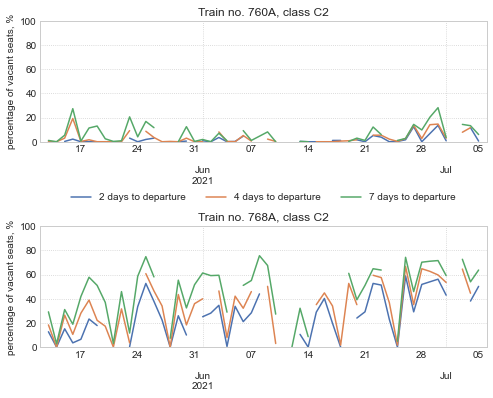

In [50]:
fig, axes = plt.subplots(nrows=len(trains))
fig.set_size_inches(8, 6)
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    for i, day in enumerate(days):
        ts = data[(data['train'] == train) & (data['days'] == day)]\
            .set_index('date')['places_frac'].reindex(all_dates) * 100
        
        ts.plot(ax=ax, c=f'C{i}', label=f'{day} days to departure')
        
    ax.set_xlabel(None)
    ax.set_ylabel('percentage of vacant seats, %')
    ax.set_ylim(0, 100)
    
    num, cls = train.split('-')
    ax.set_title(f'Train no. {num}, class {cls}')
    
axes[0].legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.35))

plt.savefig(figures_dir / 'seat_dynamics_dates.pdf', transparent=True, bbox_inches='tight')

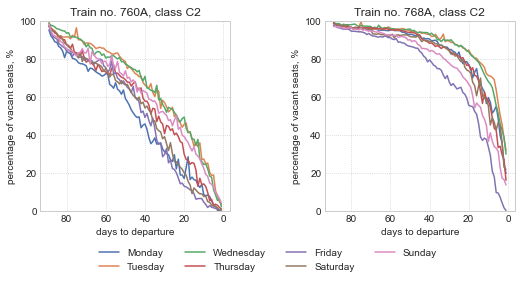

In [53]:
fig, axes = plt.subplots(ncols=len(trains))
fig.set_size_inches(8.5, 3.5)
fig.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for train, ax in zip(trains, axes):
    for i, weekday in weekdays.items():
        ts = data[(data['train'] == train) & (data['day_name'] == weekday)]\
            .groupby('days')['places_frac'].mean() * 100
        
        ts.plot(ax=ax, c=f'C{i}', label=weekday)
        
    ax.invert_xaxis()
    ax.set_xlabel('days to departure')
    ax.set_ylabel('percentage of vacant seats, %')
    ax.set_ylim(0, 100)
    
    num, cls = train.split('-')
    ax.set_title(f'Train no. {num}, class {cls}')
    
axes[0].legend(loc='upper center', ncol=4, bbox_to_anchor=(1.2, -0.15))

plt.savefig(figures_dir / 'seat_dynamics_days.pdf', transparent=True, bbox_inches='tight')

In [152]:
data_ = data[(data['train'] == '768А-C2') & (data['days'] <= 30)]\
    .pivot(index='date', columns='days', values='places_frac')

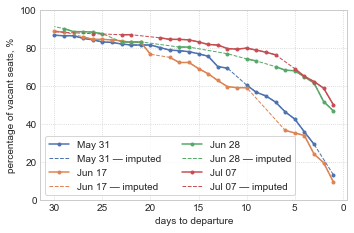

In [159]:
idx = [34, 50, 61, 68]

plt.figure(figsize=(5.5, 3.5))

for i, j in enumerate(idx):
    ts = data_.iloc[j] * 100
    ts_imp = pd.Series(impute_average(ts.values, lim=(0, 100)), index=ts.index)
    
    color = f'C{i}'
    date = data_.index[j].strftime('%b %d')
    
    ts.plot(c=color, marker='.', label=f'{date}')
    ts_imp.plot(c=color, ls='dashed', lw=1, label=f'{date} — imputed')
    
plt.legend(ncol=2, frameon=True)
plt.ylim(0, 100)

plt.gca().invert_xaxis()
plt.xlabel('days to departure')
plt.ylabel('percentage of vacant seats, %')

plt.savefig(figures_dir / 'imputation.pdf', transparent=True, bbox_inches='tight')